In [1]:
import elicito as el
import tensorflow as tf
import tensorflow_probability as tfp
from elicito.networks import InvertibleNetwork
import copy

tfd = tfp.distributions

In [2]:
class GenerativeModel:
    def __call__(self, prior_samples, design_matrix, n_gr):
        # extract prior samples per parameter type
        betas=prior_samples[:,:,:-1]
        sigma=prior_samples[:,:,-1][:,:,None]
        # linear predictor
        mu = tf.matmul(betas, design_matrix, transpose_b=True)
        # data-generating model
        y = tfd.Normal(loc=mu, scale=sigma).sample()
        # selected observations per group
        (y_gr0, y_gr1, y_gr2) = (y[:, :, i::] for i,j in zip(
            [0,n_gr,2*n_gr],[n_gr,2*n_gr,-1]))
        return dict(y_gr0=y_gr0, y_gr1=y_gr1,
                    y_gr2=y_gr2, mu=mu, y=y)

# design-matrix for three-level dummy-coded predictor
def design_categorical(n_gr):
    incpt = [1]*3
    contrast_01 = [0, 1, 0]
    contrast_02 = [0, 0, 1]
    # contrast matrix
    c = tf.stack([incpt, contrast_01, contrast_02], axis=-1)
    # design matrix
    x = tf.concat([tf.broadcast_to(c[i, :], (n_gr, c.shape[1])) for
                   i in range(c.shape[0])], axis=0)
    return tf.cast(x, tf.float32)

model=el.model(
    obj=GenerativeModel,
    n_gr=30,
    design_matrix=design_categorical(n_gr=30)
)

parameters=[
    el.parameter(
        name=f"beta{i}",
        family=tfd.Normal,
        hyperparams=dict(loc=el.hyper(f"mu{i}"),
        scale=el.hyper(f"sigma{i}", lower=0))
        ) for i in range(3)
    ]+[
    el.parameter(
        name="sigma",
        family=tfd.HalfNormal,
        hyperparams=dict(scale=el.hyper("sigma3", lower=0))
    ),
]

def r2(y, mu):
    return tf.divide(
        tf.math.reduce_variance(mu, axis=-1),
        tf.math.reduce_variance(y, axis=-1)
    )

targets=[
    el.target(
        name=f"y_gr{i}",
        query=el.queries.quantiles(quantiles=(.25, .50, .75)),
        loss=el.losses.MMD2(kernel="energy"),
        ) for i in range(3)
    ]+[
        el.target(
        name="r2",
        query=el.queries.quantiles(quantiles=(.25, .50, .75)),
        loss=el.losses.MMD2(kernel="energy"),
        target_method=r2,
        )
]

expert = el.expert.data(
    dat={'quantiles_y_gr0': [0.64, 1.22, 1.89],
        'quantiles_y_gr1': [0.72, 1.39, 2.07],
        'quantiles_y_gr2': [0.76, 1.48, 2.22],
        'quantiles_r2': [0.07, 0.23, 0.61]}
    )

optimizer=el.optimizer(
    optimizer=tf.keras.optimizers.Adam,
    learning_rate=0.05
)

trainer=el.trainer(
    method="parametric_prior",
    seed=2025,
    epochs=600,
    progress=0
)

initializer=el.initializer(
    method="random",
    iterations=32,
    distribution=el.initialization.uniform(radius=2., mean=0.)
)

eliobj = el.Elicit(
    model=model,
    parameters=parameters,
    targets=targets,
    expert=expert,
    optimizer=optimizer,
    trainer=trainer,
    initializer=initializer
)

In [4]:
eliobj.fit(parallel=el.utils.parallel(runs=5))

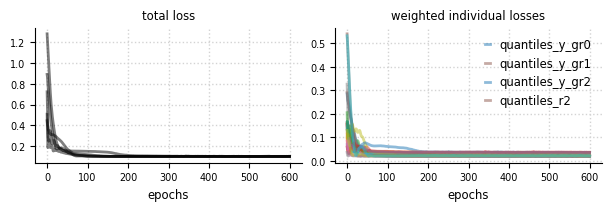

In [5]:
el.plots.loss(eliobj, figsize=(6,2))

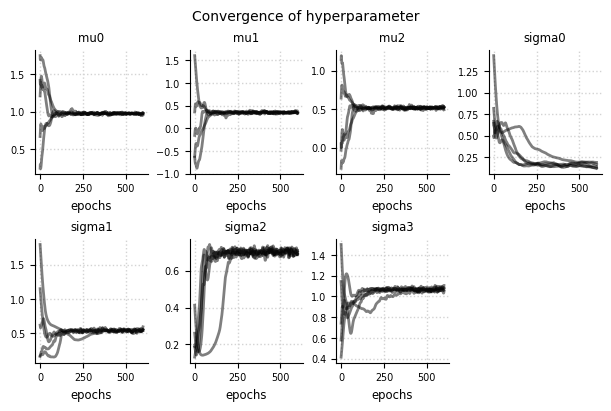

In [7]:
el.plots.hyperparameter(eliobj, figsize=(6,4))

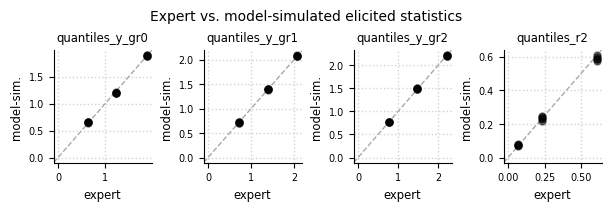

In [8]:
el.plots.elicits(eliobj, figsize=(6,2))

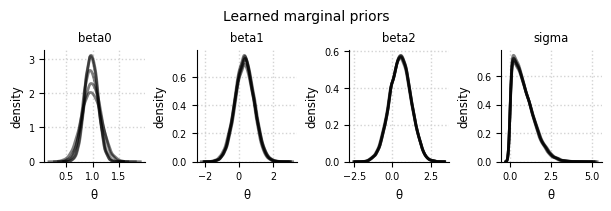

In [10]:
el.plots.prior_marginals(eliobj, figsize=(6,2))

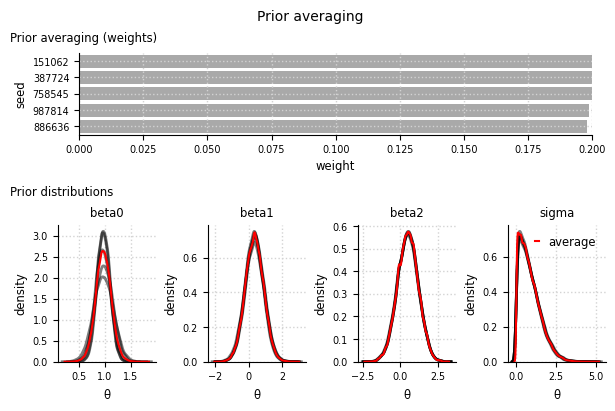

In [12]:
el.plots.prior_averaging(eliobj, figsize=(6,4))

In [3]:
parameters_deep=[
    el.parameter(name=f"beta{i}") for i in range(3)
    ]+[
    el.parameter(name="sigma", lower=0),
]

optimizer_deep=el.optimizer(
    optimizer=tf.keras.optimizers.Adam,
    learning_rate=0.001
)

trainer_deep=el.trainer(
    method="deep_prior",
    seed=2025,
    epochs=800,
    progress=0
)

network=el.networks.NF(
    inference_network=InvertibleNetwork,
    network_specs=dict(
        num_params=4,
        num_coupling_layers=3,
        coupling_design="affine",
        coupling_settings={
            "dropout": False,
            "dense_args": {
                "units": 128,
                "activation": "relu",
                "kernel_regularizer": None,
            },
            "num_dense": 2,
        },
        permutation="fixed"
    ),
    base_distribution=el.networks.base_normal
)

In [5]:
# copy existing eliobj
eliobj_deep = copy.deepcopy(eliobj)
# update eliobj
eliobj_deep.update(
    parameters=parameters_deep,
    optimizer=optimizer_deep,
    trainer=trainer_deep,
    initializer=None,
    network=network
)
# fit updated eliobj
eliobj_deep.fit(parallel=el.utils.parallel(runs=5))

INFO: Results have been reset.


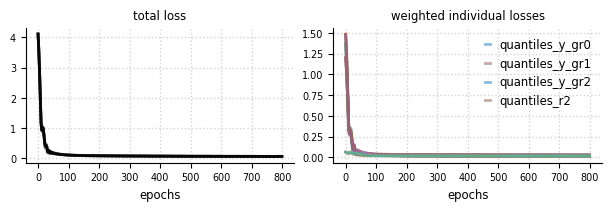

In [6]:
el.plots.loss(eliobj_deep, figsize=(6,2))

INFO: Reset cols=2


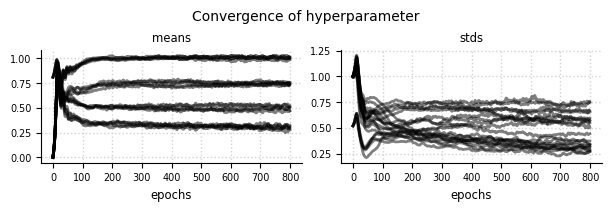

In [7]:
el.plots.hyperparameter(eliobj_deep, figsize=(6,2))

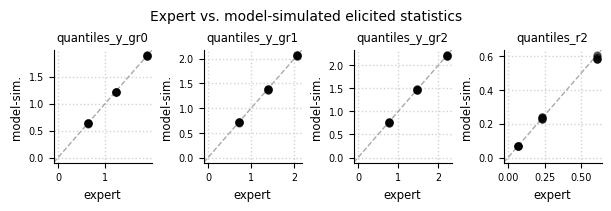

In [8]:
el.plots.elicits(eliobj_deep, figsize=(6,2))

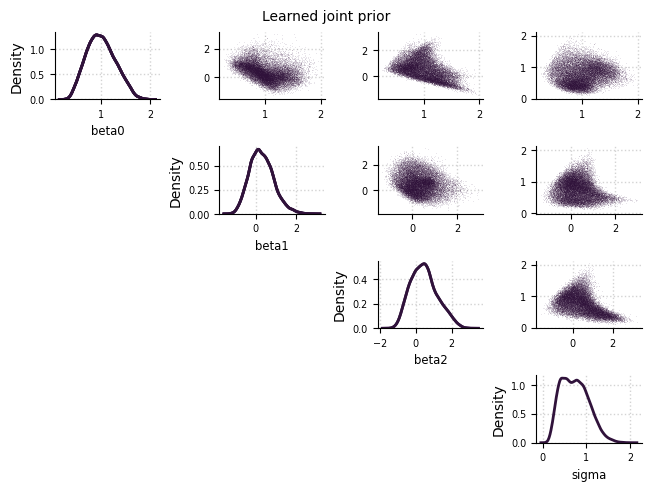

In [9]:
el.plots.prior_joint(eliobj_deep)

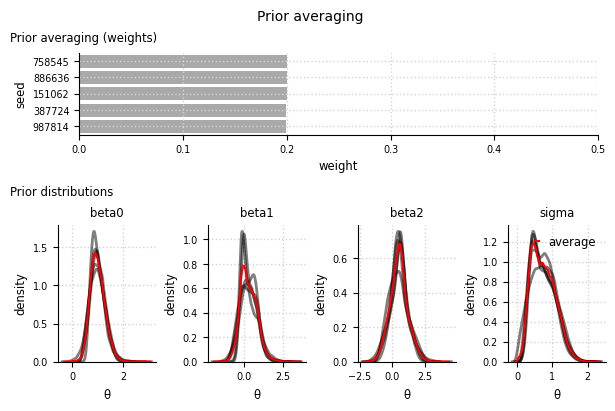

In [13]:
el.plots.prior_averaging(eliobj_deep, figsize=(6,4), xlim_weights=0.5)